## Bagging
This method will use **bagging** for **positive-unlabeled** classifier learning [(Mordelet and Vert, 2014)](https://www.sciencedirect.com/science/article/pii/S0167865513002432?via%3Dihub)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Randomly choose other datapoints to also be positive, and make all others negative
3. Rinse and repeat, aggregating classification scores

In [1]:
from QC import *
sc.settings.set_figure_params(dpi=80)

In [ ]:
# reload fcc module while working
import sys
del sys.modules['QC']
from QC import *

### Load data and preprocess

Read in normal human colon sample

In [2]:
%time s1 = sc.read_h5ad('data/3247-AS-1-GCCAAT_S1_labeled.h5ad')

CPU times: user 11.8 s, sys: 3.59 s, total: 15.4 s
Wall time: 18.3 s


In [3]:
s1 # see what's in our object

AnnData object with n_obs × n_vars = 19128 × 41569 
    obs: 'mean_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'label'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Find inflection point

Inflection point at index
bcEGRW     3541
bcGOPG     5895
bcFVGH     8972
bcFUGA    12242
bcGPGA    15618
bcDZKU    19127
Name: total_counts, dtype: int64 for [0, 20, 40, 60, 80, 100] percentiles of greatest secant distances


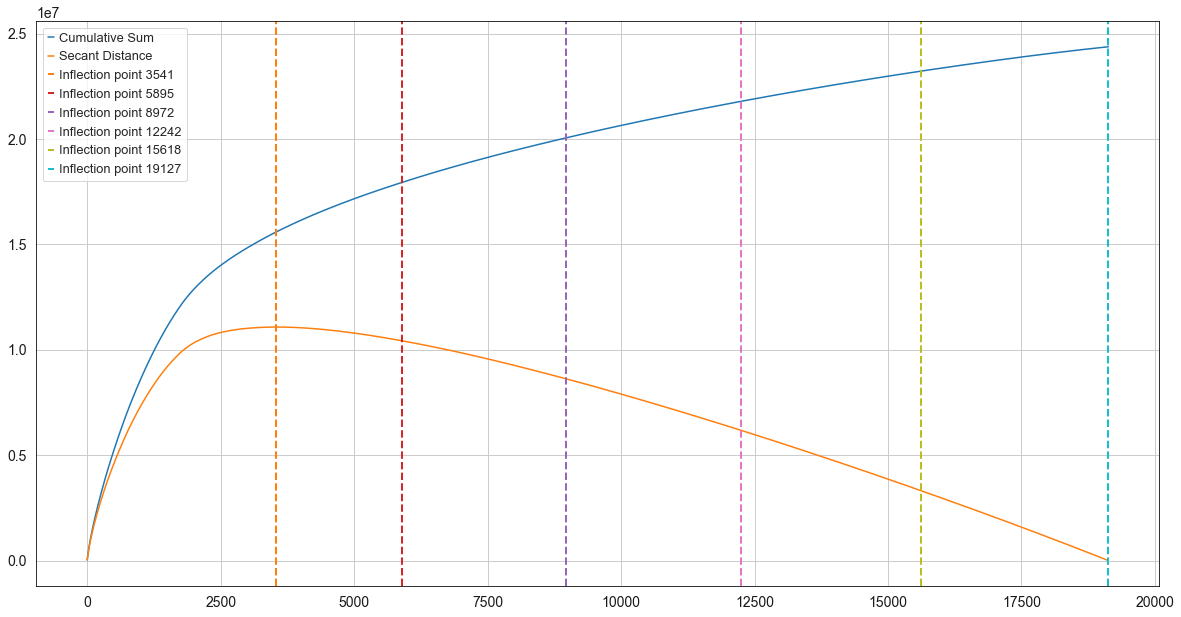

In [6]:
find_inflection(s1, inflection_percentiles = [0,20,40,60,80,100])

In [7]:
s1.obs['total_counts'][12242] # see the total counts at 80th percentile of secant distance (beyond inflection point)

473.0

In [8]:
# create new "observation" as empty droplet label
s1.obs['bagging_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][12242], 1, 0) # 1 is "empty", 0 is __initially__ "not empty"

In [9]:
s1.obs['bagging_empty'].value_counts()

0    12218
1     6910
Name: bagging_empty, dtype: int64

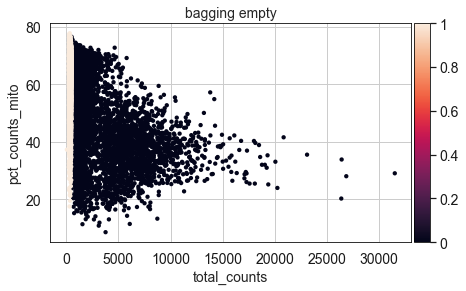

In [10]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='bagging_empty', size=75)

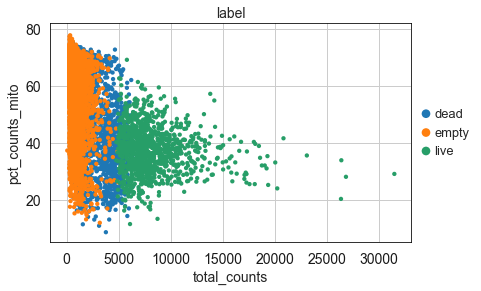

In [11]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='label', size=75)

### Normalize and perform linear dimensionality reduction with PCA
Principal components will be fed into classifiers to speed up processing time by reducing gene dimensions to 100 from 40k+.

In [12]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p transformation
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 11.4 s, sys: 1.9 s, total: 13.3 s
Wall time: 15.9 s


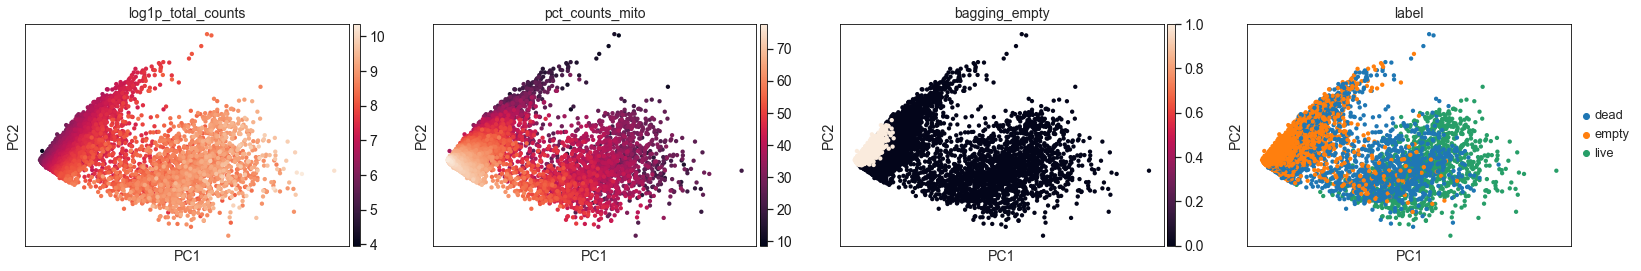

CPU times: user 3min 2s, sys: 3.89 s, total: 3min 6s
Wall time: 1min 19s


In [13]:
%%time
sc.tl.pca(s1, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1, color=['log1p_total_counts','pct_counts_mito','bagging_empty','label'], ncols=4, size=75)

In [14]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['bagging_empty'].copy(deep=True) # training labels are from .obs df

In [15]:
%%time
from baggingPU import BaggingClassifierPU
from sklearn.tree import DecisionTreeClassifier

bc = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)

results_bagging_empty = bc.oob_decision_function_[:,1]

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


CPU times: user 10.8 s, sys: 497 ms, total: 11.3 s
Wall time: 3min 33s


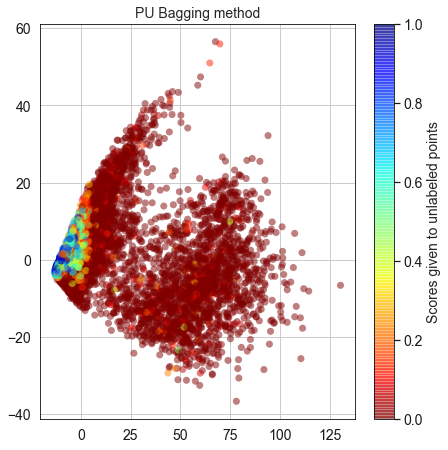

In [16]:
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()